In [1]:
!pip install -q tensorflowjs
!nvidia-smi

     |████████████████████████████████| 77 kB 2.1 MB/s 
     |████████████████████████████████| 462 kB 11.8 MB/s 
Mon Feb 21 18:59:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+---------------------

In [1]:
#@title Runtime
use_tpu = False #@param

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import tensorflow as tf
import urllib
from dataclasses import dataclass
import tensorflowjs as tfjs
import json
np.random.seed(0)

In [3]:
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/insoluble.npz",
    "insoluble.npz",
)
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/soluble.npz",
    "soluble.npz",
)
with np.load("soluble.npz") as r:
    pos_data = r['arr_0']
with np.load("insoluble.npz") as r:
    neg_data = r['arr_0']

# create labels and stich it all into one
# tensor
labels = np.concatenate(
    (
        np.ones((pos_data.shape[0], 1), dtype=pos_data.dtype),
        np.zeros((neg_data.shape[0], 1), dtype=pos_data.dtype),
    ),
    axis=0,
)
features = np.concatenate((pos_data, neg_data), axis=0)
pos_data_lengths = np.count_nonzero(pos_data, axis=1)
neg_data_lengths = np.count_nonzero(neg_data, axis=1)

In [4]:
print('Positive data', pos_data.shape[0])
print('Negative data', neg_data.shape[0])

Positive data 8785
Negative data 9668


In [48]:
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    rnn_units: int
    hidden_dim: int
    embedding_dim: int
    reg_strength: float
    lr: float
    drop_rate: float
        
config = Config(vocab_size=21, # include gap
                example_number=len(labels), 
                batch_size=16, 
                buffer_size=10000,
                rnn_units=64,
                hidden_dim=64,
                embedding_dim=32,
                reg_strength=0.01,
                lr=1e-4,
                drop_rate=0.2
               )



In [49]:
def counts_aa(vec):
    counts =  tf.histogram_fixed_width(vec, [0, 20], nbins=21)[1:]
    return counts /tf.reduce_sum(counts)

def build_model(L):
    inputs = tf.keras.Input(shape=(L,))
    input_f = tf.keras.Input(shape=(20,))
    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
                                        output_dim=config.embedding_dim,
                                        mask_zero=True)(inputs)

    # RNN layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units, return_sequences=True))(e)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units))(x)
    x = tf.keras.layers.Concatenate()([x, input_f])
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(
        config.hidden_dim, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    x = tf.keras.layers.Dense(
        config.hidden_dim // 4, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # predicting prob, so no activation
    yhat = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=[inputs, input_f], outputs=yhat, name='sol-rnn')
    return model

def build_infer_model(L):
    inputs = tf.keras.Input(shape=(L,))
    input_f = tf.keras.Input(shape=(20,))
    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
                                        output_dim=config.embedding_dim,
                                        mask_zero=True)(inputs)


    # RNN layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units, return_sequences=True))(e)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units))(x)
    x = tf.keras.layers.Concatenate()([x, input_f])
    x = tf.keras.layers.LayerNormalization()(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(
        config.hidden_dim, 
        activation='relu')(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dense(
        config.hidden_dim // 4, 
        activation='relu')(x)
    x = tf.keras.layers.LayerNormalization()(x)
    # predicting prob, so no activation
    yhat = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[inputs, input_f], outputs=yhat, name='sol-rnn-infer')
    return model

In [50]:
if use_tpu:
  tf.keras.backend.clear_session()

  resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)

  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))

  strategy = tf.distribute.experimental.TPUStrategy(resolver)


In [59]:
# we now need to shuffle before creating TF dataset
# so that our train/test/val splits are random
i = np.arange(len(labels))
np.random.shuffle(i)
np.random.shuffle(i)
np.random.shuffle(i)
shuffled_labels = labels[i]
shuffled_features = features[i]
data = tf.data.Dataset.from_tensor_slices((shuffled_features, shuffled_labels)).map(lambda x,y: ((x, counts_aa(x)), y))
# now split into val, test, train and batch
N = len(data)  
L = None#features[0].shape[-1]
split = int(0.1 * N)
test_data = data.take(split).batch(config.batch_size)
nontest = data.skip(split)
val_data, train_data = nontest.take(split).batch(config.batch_size), \
    nontest.skip(split).shuffle(config.buffer_size).batch(config.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [60]:
tf.keras.backend.clear_session()
if use_tpu:
  with strategy.scope():
    model = build_model(L)
else:
  model = build_model(L)

  # 50 epochs
  decay_steps = N  // config.batch_size * 50
  lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
      config.lr, decay_steps, alpha=1e-3)
  opt = tf.optimizers.Adam(lr_decayed_fn)
  model.compile(
      opt,
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
      steps_per_execution = 60 if use_tpu else None,
      metrics=[tf.keras.metrics.AUC(from_logits=True), tf.keras.metrics.BinaryAccuracy(threshold=0)])

In [61]:
model.summary()

Model: "sol-rnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 32)     672         ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, None, 128)    49664       ['embedding[0][0]']              
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 128)         98816       ['bidirectional[0][0]']          
 )                                                                                          

In [62]:
# model.fit(
#     train_data, 
#     validation_data=val_data, 
#     callbacks=[tf.keras.callbacks.LambdaCallback(
#         on_epoch_begin=lambda epochs,logs: print('lr =',lr_decayed_fn(opt.iterations).numpy())
#         )],
#     epochs=100)

result = model.fit(
    train_data, 
    validation_data=val_data, 
    callbacks=[tf.keras.callbacks.LambdaCallback(
        on_epoch_begin=lambda epochs,logs: print('lr =',lr_decayed_fn(opt.iterations).numpy())
        ),
          tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', restore_best_weights=True, patience=5)],
    epochs=150)



lr = 1e-04
Epoch 1/150
923/923 [==============================] - 43s 36ms/step - loss: 1.7488 - auc: 0.5185 - binary_accuracy: 0.5154 - val_loss: 1.5007 - val_auc: 0.5848 - val_binary_accuracy: 0.5621
lr = 9.993683e-05
Epoch 2/150
923/923 [==============================] - 31s 33ms/step - loss: 1.3966 - auc: 0.5240 - binary_accuracy: 0.5212 - val_loss: 1.2211 - val_auc: 0.6484 - val_binary_accuracy: 0.6081
lr = 9.974747e-05
Epoch 3/150
923/923 [==============================] - 30s 33ms/step - loss: 1.1590 - auc: 0.5740 - binary_accuracy: 0.5533 - val_loss: 1.0462 - val_auc: 0.6565 - val_binary_accuracy: 0.6049
lr = 9.9432415e-05
Epoch 4/150
923/923 [==============================] - 30s 33ms/step - loss: 1.0051 - auc: 0.6150 - binary_accuracy: 0.5846 - val_loss: 0.9302 - val_auc: 0.6688 - val_binary_accuracy: 0.6217
lr = 9.899245e-05
Epoch 5/150
923/923 [==============================] - 30s 33ms/step - loss: 0.9059 - auc: 0.6360 - binary_accuracy: 0.5951 - val_loss: 0.8508 - val_auc

116/116 [==============================] - 2s 13ms/step - loss: 0.5870 - auc: 0.7582 - binary_accuracy: 0.7003


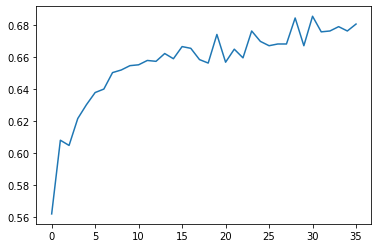

In [63]:
plt.plot(result.history['val_binary_accuracy'])
test_result = model.evaluate(test_data)
plt.show()

In [64]:
X_test, y_test = [], []
for f, l in test_data.unbatch():
  X_test.append(f)
  y_test.append(l)
y_test = [m.numpy()[0] for m in y_test]
y_hat_test = []
for m,n in X_test:
    y_hat_test.append(model.predict([m[tf.newaxis, ...], n[tf.newaxis, ...]])[0,0])

(array([976.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 869.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

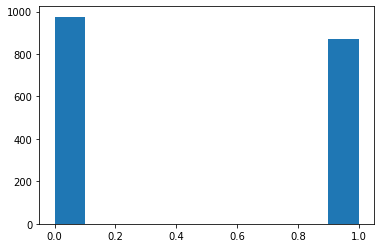

In [65]:
plt.hist(y_test)

In [87]:
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
fpr, tpr, thresholds = roc_curve(y_test, y_hat_test, drop_intermediate=False)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
best_accuracy_threshold = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
adjusted_y_hat_test = [1 if m>best_accuracy_threshold else 0 for m in y_hat_test]
acc = accuracy_score(y_test, adjusted_y_hat_test, normalize=True)
print(f'Accuracy: {acc:.3f}')

Best Threshold=-0.089385, G-Mean=0.693
Accuracy: 0.701


In [88]:
inference_model = build_infer_model(L)

inference_model.set_weights(model.get_weights())

In [89]:
inference_model([np.array([1,1,1,1]).reshape(1,-1), np.array(np.ones(20)/20).reshape(1,-1)])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9739087]], dtype=float32)>

In [90]:
# serialize model to JSON
inference_model_json = inference_model.to_json()
with open("../models/sol-rnn/keras_model/model.json", "w") as json_file:
    json_file.write(inference_model_json)
# serialize weights to HDF5
inference_model.save_weights("../models/sol-rnn/keras_model/model_weights.h5")

In [91]:
tfjs.converters.save_keras_model(inference_model, "../models/sol-rnn/")

# Model Card

In [92]:
model_card = {
    'title': 'Solubility Prediction',
    'details': 'Recurrent (bi-LSTM) neural network with concatenated amino acid frequencies for predicting solubility. Developed by Andrew White and Mehrad Ansair using data from PROSO II database in TFJS.',
    'use': 'Peptides or proteins expressed in E. coli that are less than 200 residues long. May provide solubility predictions more broadly applicable.',
    'factors': 'Solubility was defined in PROSO II as sequence that was transfectable, expressible, secretable, separable, and soluble in E. coli system.',
    'metrics': f'Test accuracy {test_result[2]:.2f}. Test AUC {test_result[1]:.2f}',
    'evaluation': 'Withheld positive and negative examples',
    'training': f'{len(pos_data) + len(neg_data)} positive (length range: {np.min(pos_data_lengths)}-{np.max(pos_data_lengths)}) and negative (length range: {np.min(neg_data_lengths)}-{np.max(neg_data_lengths)}) sequences.',
    'caveats': 'This data is mostly long sequences and so may not be as applicable to solid-phase synthesized peptides. The model accuracy is low.',
    'ethics': 'None noted'
}
with open('../models/sol-rnn/card.json', 'w') as f:
  json.dump(model_card, f)
print(json.dumps(model_card, indent=True))

{
 "title": "Solubility Prediction",
 "details": "Recurrent (bi-LSTM) neural network with concatenated amino acid frequencies for predicting solubility. Developed by Andrew White and Mehrad Ansair using data from PROSO II database in TFJS.",
 "use": "Peptides or proteins expressed in E. coli that are less than 200 residues long. May provide solubility predictions more broadly applicable.",
 "factors": "Solubility was defined in PROSO II as sequence that was transfectable, expressible, secretable, separable, and soluble in E. coli system.",
 "metrics": "Test accuracy 0.70. Test AUC 0.76",
 "evaluation": "Withheld positive and negative examples",
 "training": "18453 positive (length range: 19-198) and negative (length range: 22-198) sequences.",
 "caveats": "This data is mostly long sequences and so may not be as applicable to solid-phase synthesized peptides. The model accuracy is low.",
 "ethics": "None noted"
}
